In [6]:
import os
import json
import pandas as pd
from datetime import datetime

DATA_DIR = 'data'

dynasty_rows = []
redraft_rows = []

for filename in os.listdir(DATA_DIR):
    if filename.endswith('.json'):
        filepath = os.path.join(DATA_DIR, filename)
        with open(filepath, 'r') as f:
            data = json.load(f)
            # Use 'lastUpdated' field for timestamp if available, else fallback to file mtime
            last_updated = data.get('lastUpdated')
            if last_updated:
                try:
                    # Remove 'Z' if present and parse as UTC
                    timestamp = datetime.fromisoformat(last_updated.replace('Z', '+00:00'))
                except Exception:
                    timestamp = datetime.fromtimestamp(os.path.getmtime(filepath))
            else:
                timestamp = datetime.fromtimestamp(os.path.getmtime(filepath))
            # Dynasty
            dynasty_row = {'timestamp': timestamp, 'filename': filename}
            if data.get('rankedByDynasty') and 'teams' in data['rankedByDynasty']:
                for team in data['rankedByDynasty']['teams']:
                    team_name = team.get('name', '')
                    overall_value = team.get('overallValue', None)
                    if team_name:
                        dynasty_row[f'dynasty_team_{team_name}'] = overall_value
            dynasty_rows.append(dynasty_row)
            # Redraft
            redraft_row = {'timestamp': timestamp, 'filename': filename}
            if data.get('rankedByRedraft') and 'teams' in data['rankedByRedraft']:
                for team in data['rankedByRedraft']['teams']:
                    team_name = team.get('name', '')
                    overall_value = team.get('overallValue', None)
                    if team_name:
                        redraft_row[f'redraft_team_{team_name}'] = overall_value
            redraft_rows.append(redraft_row)

# Create DataFrames
df_dynasty = pd.DataFrame(dynasty_rows).sort_values('timestamp').reset_index(drop=True)
df_redraft = pd.DataFrame(redraft_rows).sort_values('timestamp').reset_index(drop=True)

# Save to CSV (optional)
df_dynasty.to_csv('dynasty_rankings_by_timestamp.csv', index=False)
df_redraft.to_csv('redraft_rankings_by_timestamp.csv', index=False)

C:\Users\andre\AppData\Local\Temp\ipykernel_32892\3722412709.py:12: UserWarning: Glyph 128081 (\N{CROWN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\andre\AppData\Local\Temp\ipykernel_32892\3722412709.py:12: UserWarning: Glyph 127477 (\N{REGIONAL INDICATOR SYMBOL LETTER P}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\andre\AppData\Local\Temp\ipykernel_32892\3722412709.py:12: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


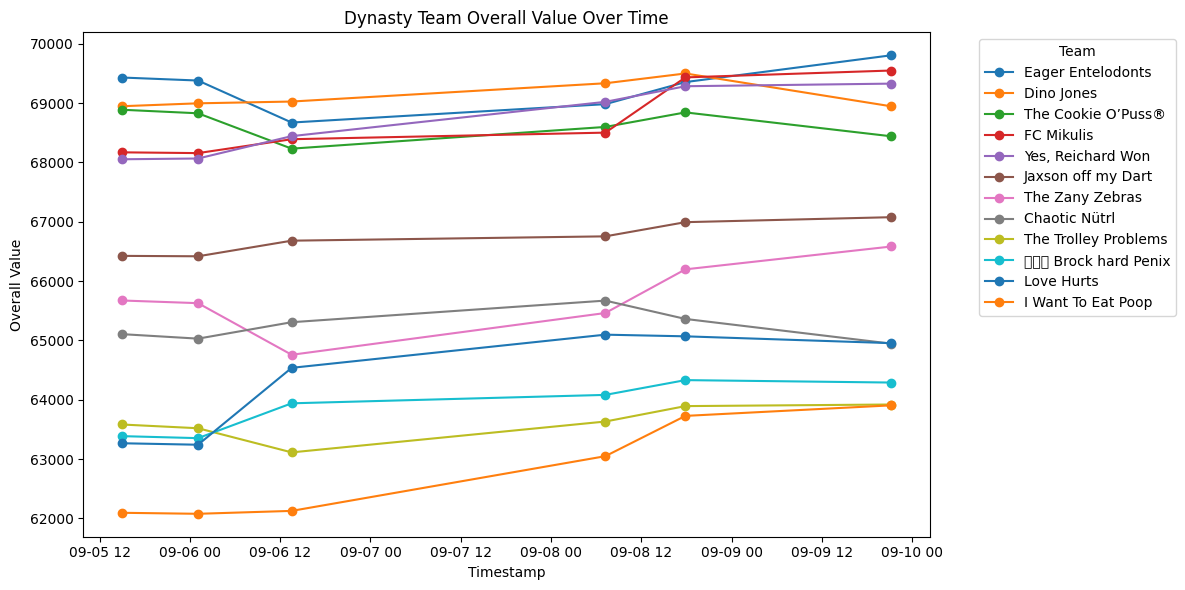

In [7]:
import matplotlib.pyplot as plt

# Dynasty plot
plt.figure(figsize=(12, 6))
for col in df_dynasty.columns:
    if col.startswith('dynasty_team_'):
        plt.plot(df_dynasty['timestamp'], df_dynasty[col], marker='o', label=col.replace('dynasty_team_', ''))
plt.title('Dynasty Team Overall Value Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Overall Value')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_32892\33931916.py:10: UserWarning: Glyph 128081 (\N{CROWN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\andre\AppData\Local\Temp\ipykernel_32892\33931916.py:10: UserWarning: Glyph 127477 (\N{REGIONAL INDICATOR SYMBOL LETTER P}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\andre\AppData\Local\Temp\ipykernel_32892\33931916.py:10: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


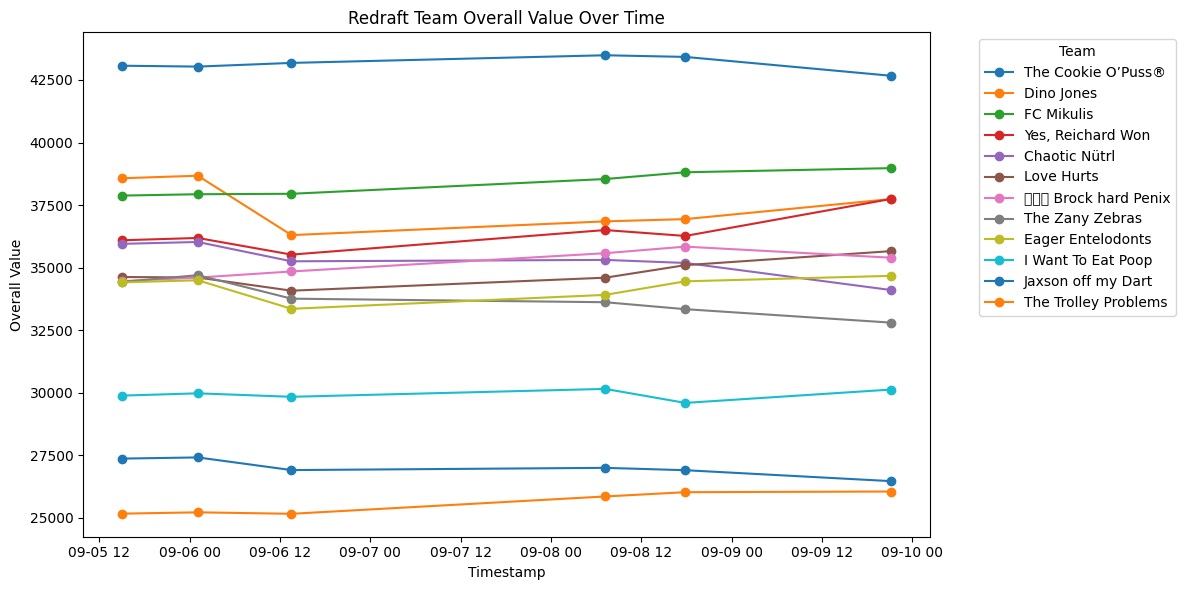

In [8]:
# Redraft plot
plt.figure(figsize=(12, 6))
for col in df_redraft.columns:
    if col.startswith('redraft_team_'):
        plt.plot(df_redraft['timestamp'], df_redraft[col], marker='o', label=col.replace('redraft_team_', ''))
plt.title('Redraft Team Overall Value Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Overall Value')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()